<a href="https://colab.research.google.com/github/NoeGille/UNet-on-fashion-mnist/blob/main/UNet_on_fashion_MNIST_Florian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate the dataset

In [56]:
import os
import random
import numpy as np
# import matplotlib
# matplotlib.use('TkAgg') # Necessary to run matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import albumentations as A
import torch
from torchvision import transforms
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim


import copy

from collections import OrderedDict

from PIL import Image

from torchvision import datasets
from torchvision import transforms
import numpy as np
import random

In [57]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
NUM_CLASSES = 10
BATCH_SIZE = 16
EPOCHS = 10

In [58]:
train_dataset = datasets.FashionMNIST(root='./data', train = True, download=True)
valid_dataset = datasets.FashionMNIST(root='./data', train = False, download=True)

In [59]:
class FashionMNISTDataset(Dataset):
    def __init__(self, dataset, transform = None, 
                 shape = 224, labels = [1, 2, 3], 
                 not_labels = [5, 6, 7], background_obj = 3, 
                 include_label = True, length = 10000):
        self.dataset = dataset
        self.transform = transform
        self.shape = shape
        self.labels = labels
        self.not_labels = not_labels
        self.background_obj = background_obj
        self.include_label = include_label
        self.len = length
    
    def random_fashion_mnist(self):
        idx = np.random.randint(0, len(self.dataset))

        img, label = self.dataset[idx]
        img = transforms.ToTensor()(img)
        return img, label
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, i):
        
        image = torch.zeros((1, self.shape, self.shape))#, dtype=torch.uint8)
        mask = torch.zeros((self.shape, self.shape))#, dtype=torch.uint8)

        x = random.randint(14, self.shape - 114)
        y = x

        points = [(x, y), (x + 100, y), (x + 100, y + 100), (x, y + 100)]

        for i in points:
            while True:
              img, label = self.random_fashion_mnist()
              if label in self.labels:
                break
            
            x_pos, y_pos = i[0] - 14, i[1] - 14
            image[:, x_pos:x_pos+28, y_pos:y_pos+28] = img
            mask[x_pos:x_pos+28, y_pos:y_pos+28] = self.include_label * label + 1
            mask[x_pos:x_pos + 28, y_pos:y_pos + 28][img[0, :, :] == 0] = 0
        
        for i in range(self.background_obj):
          while True:
              img, label = self.random_fashion_mnist()
              if label in self.not_labels:
                break
          while True:
            x = random.randint(0, self.shape - 28)
            y = x
            if (mask[x:x+28, y:y+28] * img).sum().item() == 0:
                break
          image[:, x:x + 28, y:y + 28] = img
        
        if self.transform is not None:
            image = image.permute(1, 2, 0)
            image = np.array(image)
            mask = np.array(mask)
            transformed = self.transform(image = image, mask = mask)
            image = transformed["image"]
            mask = transformed["mask"]
            image = transforms.ToTensor()(image).to(torch.float)
            mask = torch.from_numpy(mask).long()
        return image, mask
    

In [60]:
p = 0.1
p_ = 0.2

train_transform = A.Compose(
    [
        A.HorizontalFlip(p = p),
        A.VerticalFlip(p = p),
        A.geometric.rotate.Rotate(limit = 180, p = p_),
    ]
)

valid_transform = A.Compose(
    [
        
    ]
)

In [61]:
labels = [1, 2, 3]
not_labels = [1, 2, 3, 5, 6, 7]
num_background = 5
train_len = 2000
valid_len = 2000

train_data = FashionMNISTDataset(dataset = train_dataset, transform = train_transform, length = train_len, labels = labels, not_labels = not_labels, background_obj = num_background)#None)#transform = train_transform)
valid_data = FashionMNISTDataset(dataset = valid_dataset, transform = valid_transform, length = valid_len, labels = labels, not_labels = not_labels, background_obj = num_background)#transform = None)#valid_transform)
print(len(train_data), len(valid_data))

2000 2000


torch.Size([1, 224, 224]) torch.Size([224, 224])


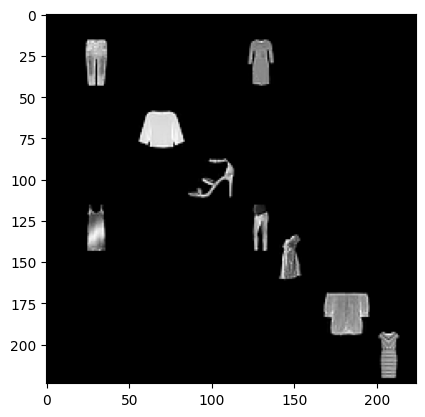

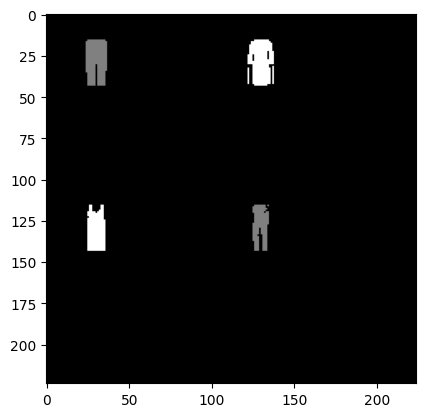

In [62]:
sample_image, sample_mask = train_data[0]
print(sample_image.shape, sample_mask.shape)
sample_image_to_show = sample_image.permute(1, 2, 0)
plt.figure()
plt.imshow(sample_image_to_show, cmap = 'gray')
plt.figure()
plt.imshow(sample_mask, cmap = 'gray')

In [63]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(valid_data, batch_size = BATCH_SIZE, shuffle = True)

In [64]:
# Experiments

## Different classes for foreground and background objects
## Intersecting classes for foreground and background objects

### Train shallow and deep models
### Visualize predictions once model has trained
### Evaluate using dice score
### Evaluate using precision and recall

In [65]:
LEARNING_RATE = 0.001
INPUT_SIZE = (224, 224, 1)

# A faire : ajouter des batch normalization si problème de valeur extremes en sorties


class DownSampleBlock(nn.Module):
    '''Reduce the dimension of the image in input by 2'''
    def __init__(self, in_channels, out_channels):
        super(DownSampleBlock, self).__init__()
        # We keep the same dimension in input and ouput
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2,2))

    def forward(self, x):
        x = self.norm2(self.conv2(self.relu(self.norm1(self.conv1(x)))))
        return self.pool(x), x

class DoubleConvolution(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvolution, self).__init__()
        # We keep the same dimension in input and ouput
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
      x = self.norm2(self.conv2(self.relu(self.norm1(self.conv1(x)))))
      return x

class UpSampleBlock(nn.Module):
    '''Increase the dimension of the input and reduce its number of channels by 2'''
    def __init__(self, in_channels):
        super(UpSampleBlock, self).__init__()
        self.up1 = nn.ConvTranspose2d(in_channels, in_channels, 2, 2)
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                                     out_channels=in_channels, kernel_size=(3, 3),
                                     stride=(1, 1), padding=(1,1))
        
    def forward(self, x):
        x = self.conv1(self.up1(x))
        return x

class ResidualConnection(nn.Module):
    '''Concatenate inputs of two blocs'''

    def __init__(self, in_channels, out_channels):
        '''in_channels has the same dimensions as out_channels'''

        super(ResidualConnection, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels * 2, out_channels=in_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))
        self.norm2 = nn.BatchNorm2d(out_channels)

    def forward(self, x1, x2):
        x = torch.cat([x2, x1], dim=1)
        x = self.norm2(self.conv2(self.relu(self.norm1(self.conv1(x)))))
        return x

class UNet(nn.Module):

    # Numbers of filters for the first layer of convolution
    # <!> The number of filters will double for each down sample blocks which can
    # lead to very high numbers of parameters very quickly <!>
    NB_OF_FILTERS = 16

    def __init__(self, input_size, num_classes:int=10, depth:int=2):
        '''### Initialize a UNet model
        input_size : dimension of input
        num_classes : specify the number of classes in ouput
        depth : the number of blocks (depth of the model)'''
        super(UNet, self).__init__()
        channels = [input_size[-1]] + [self.NB_OF_FILTERS * (i + 1) for i in range(depth)]
        # first downsampling block
        self.dblocks = nn.ModuleList([DownSampleBlock(in_channels=channels[0], out_channels=channels[1])])
        self.bottleneck = DoubleConvolution(in_channels=channels[-1], out_channels=channels[-1])
        # Concatenate outputs from encoder and decoder to keep tracks of objects positions
        self.res_connect = nn.ModuleList([ResidualConnection(in_channels=channels[1], out_channels=num_classes)])
        # Last upsampling block
        self.ublocks = nn.ModuleList([UpSampleBlock(in_channels=channels[1])])

        for i in range(1,depth):
            # The number of channels double each time the depth increases
            self.dblocks.append(DownSampleBlock(in_channels=channels[i], out_channels=channels[i + 1]))
            self.res_connect.append(ResidualConnection(in_channels=channels[i + 1], out_channels=channels[i]))
            self.ublocks.append(UpSampleBlock(in_channels=channels[i + 1]))
        self.ublocks = self.ublocks[::-1]
        self.res_connect = self.res_connect[::-1]
        self.output = nn.Conv2d(in_channels=num_classes, out_channels=num_classes,
                               kernel_size=(3, 3), stride=(1, 1), padding=(1,1))

    def forward(self, x):
        depth = len(self.dblocks)

        # Encoder
        # Copy of output of each blocks before downsampling
        xs_down =[]
        for i, down_block in enumerate(self.dblocks):
            x, copy = down_block.forward(x)
            xs_down.append(copy)
        x = self.bottleneck.forward(x)
        xs_down = xs_down[::-1]
        # Decoder
        for i, up_block in enumerate(self.ublocks):
            x_up = up_block.forward(x)
            x = self.res_connect[i](x_up, xs_down[i])
        
        x = F.softmax(self.output(x))
        
        return x


In [72]:
model = UNet(INPUT_SIZE, num_classes=NUM_CLASSES, depth=2).to(device=DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [85]:
def metrics_values(y_valid, y_pred):
    '''return values useful for computation of accuracy and dice score'''
    mask_valid_idx = y_valid.argmax(1)
    mask_pred_idx = y_pred.argmax(1)
    num_correct = mask_pred_idx.eq(mask_valid_idx).sum().item()
    num_samples = y_valid.size(0)

    # Dice score 
    valid_mask_card = torch.where(mask_valid_idx == 0, 0, 1).sum()
    pred_mask_card = torch.where(mask_pred_idx == 0, 0, 1).sum()
    intersection = torch.where((mask_valid_idx == mask_pred_idx) & (mask_pred_idx != 0), 1, 0).sum()
    return (num_correct, num_samples, valid_mask_card, pred_mask_card, intersection)

accuracies = []
dice_scores = []

for epoch in range(EPOCHS):
    num_correct = 0
    num_samples = 0
    valid_mask_card = 0
    pred_mask_card = 0
    intersection = 0
    for img, mask in tqdm(train_dataloader):
        
        img = img.to(device=DEVICE)
        mask = mask.to(device=DEVICE) # dim : (batch_size, 224, 224)
        # prediction
        mask_pred = model(img)  # dim : (batch_size, 10, 224, 224)
        mask_pred = mask_pred.contiguous().view(-1, mask_pred.size(1)).float().to(device=DEVICE) # dim : (batch_size*224*224, 10)
        # Flatten and convert to float targets for loss computation
        mask_valid = mask.contiguous().view(-1).float().to(device=DEVICE)
        id = np.eye(NUM_CLASSES)
        mask_valid = torch.from_numpy(id[np.uint8(mask_valid.cpu().numpy())]).to(device=DEVICE)
        # Calculate loss
        loss = criterion(mask_pred, mask_valid)
        # Save data for plotting
        values = metrics_values(mask_valid, mask_pred)
        num_correct += values[0]
        num_samples += values[1]
        valid_mask_card += values[2]
        pred_mask_card += values[3]
        intersection += values[4]
        # backward
        optimizer.zero_grad()
        loss.backward()

        #gradient descent or adam step
        optimizer.step()
    acc = round(float(num_correct) / float(num_samples)*100, ndigits=2)
    dice_score = round(2 * float(intersection) / (float(valid_mask_card) + float(pred_mask_card)), ndigits=2)
    print(f"accuracy {acc} and dice score {dice_score}")
    accuracies.append(acc)
    dice_scores.append(dice_score)

  0%|          | 0/125 [00:00<?, ?it/s]<ipython-input-65-cdb4692e287e>:122: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))
100%|██████████| 125/125 [00:27<00:00,  4.60it/s]


accuracy 37.02 and dice score 0.01


100%|██████████| 125/125 [00:22<00:00,  5.49it/s]


accuracy 43.24 and dice score 0.01


100%|██████████| 125/125 [00:21<00:00,  5.87it/s]


accuracy 43.51 and dice score 0.01


100%|██████████| 125/125 [00:21<00:00,  5.71it/s]


accuracy 44.38 and dice score 0.01


100%|██████████| 125/125 [00:22<00:00,  5.63it/s]


accuracy 44.26 and dice score 0.01


100%|██████████| 125/125 [00:22<00:00,  5.55it/s]


accuracy 44.84 and dice score 0.01


100%|██████████| 125/125 [00:22<00:00,  5.63it/s]


accuracy 45.06 and dice score 0.01


100%|██████████| 125/125 [00:21<00:00,  5.81it/s]


accuracy 45.54 and dice score 0.01


100%|██████████| 125/125 [00:21<00:00,  5.75it/s]


accuracy 45.35 and dice score 0.01


100%|██████████| 125/125 [00:21<00:00,  5.73it/s]


accuracy 46.17 and dice score 0.01


torch.Size([1, 224, 224]) torch.Size([224, 224])


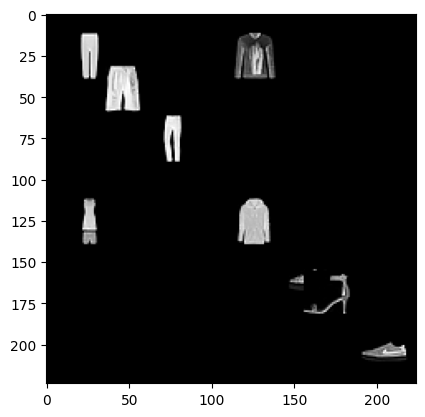

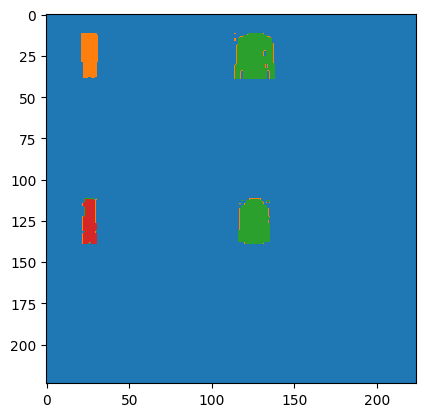

<ipython-input-65-cdb4692e287e>:122: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.output(x))


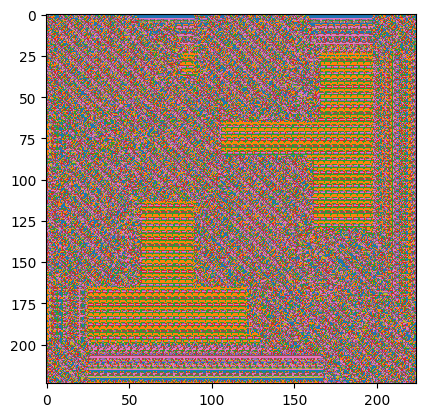

In [98]:
sample_image, sample_mask = train_data[0]
print(sample_image.shape, sample_mask.shape)
sample_image_to_show = sample_image.permute(1, 2, 0)
plt.figure()
plt.imshow(sample_image_to_show, cmap = 'gray')
plt.figure()
plt.imshow(sample_mask, vmin=1, vmax=10, cmap='tab10')
plt.show()
with torch.no_grad():
    prediction = model(torch.from_numpy(np.array([sample_image.numpy()])).to(device=DEVICE))
plt.imshow(prediction.argmax(1).permute(1,2,0).cpu().numpy(), vmin=1, vmax=10, cmap='tab10')
plt.show()